# Домашнее задание 5.2

По итоговому датасету:

1. Преобразовать текстовые данные (очистка + токенизация + нормализация).
2. Обучить модель **Word2Vec** на текстах.
3. Заполнить пропуски в числовых признаках через **SimpleImputer**.
4. Выбрать алгоритм **кластеризации** и построить кластеры.
5. Построить модель для **предсказания кластера** (supervised) с подбором гиперпараметров через **GridSearchCV**.


In [2]:
!pip install pymorphy3 gensim scikit-learn nltk # бибилотеки с которыми будем работать

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.6 MB/s eta 0:00:00


In [3]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from pymorphy3 import MorphAnalyzer

import re
import nltk
from nltk.corpus import stopwords

In [4]:
DB_FILE = "/content/articles.db"

# Открываем соединение с SQLite
conn = sqlite3.connect(DB_FILE)

# Читаем всю таблицу articles в DataFrame
df = pd.read_sql_query("SELECT * FROM articles;", conn)

# Закрываем соединение
conn.close()


In [5]:
df.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,8646f28e-3ae7-4228-b010-09ff986c4128,"Три машины столкнулись в Михайловском районе, ...",На трассе в Михайловском районе столкнулись Ni...,https://www.newsvl.ru/accidents/2025/12/05/235...,2025-12-05T15:46:32+10:00,0,2025-12-05T09:35:10.141330+00:00,0
1,43371504-4edd-441b-adb4-efae00a33a35,На трассе в районе Морского кладбища монтируют...,На трассе между Патроклом и Золотым мостом зак...,https://www.newsvl.ru/vlad/2025/12/05/235512/,2025-12-05T14:49:05+10:00,0,2025-12-05T09:35:11.446330+00:00,0
2,c226b9b6-f6a2-4ce7-8138-7e066f49c838,Во Владивостоке запретили выход на лёд,Администрация Владивостока опубликовала\nпоста...,https://www.newsvl.ru/vlad/2025/12/05/235511/,2025-12-05T14:35:48+10:00,0,2025-12-05T09:35:12.812332+00:00,0
3,fc228f76-3e0c-4d9f-9b74-657ad2ccc6b7,"Хакатон по робототехнике, конкурс красоты и яр...","В эти выходные, 6 и 7 декабря, во Владивостоке...",https://www.newsvl.ru/vlad/2025/12/05/235509/,2025-12-05T14:00:00+10:00,0,2025-12-05T09:35:14.259830+00:00,0
4,1fd9a088-3f56-4b13-b1cc-98b4f288c884,Во Владивостоке разворачивается нелегальная то...,"До Нового года ещё почти четыре недели, а на у...",https://www.newsvl.ru/vlad/2025/12/05/235510/,2025-12-05T13:45:58+10:00,0,2025-12-05T09:35:15.642832+00:00,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   guid            5000 non-null   object
 1   title           5000 non-null   object
 2   description     5000 non-null   object
 3   url             5000 non-null   object
 4   published_at    5000 non-null   object
 5   comments_count  5000 non-null   int64 
 6   created_at_utc  5000 non-null   object
 7   rating          5000 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 312.6+ KB


In [7]:
df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce")
df["created_at_utc"] = pd.to_datetime(df["created_at_utc"], errors="coerce")

df[["published_at", "created_at_utc"]].head()

,published_at,created_at_utc
0,2025-12-05 15:46:32+10:00,2025-12-05 09:35:10.141330+00:00
1,2025-12-05 14:49:05+10:00,2025-12-05 09:35:11.446330+00:00
2,2025-12-05 14:35:48+10:00,2025-12-05 09:35:12.812332+00:00
3,2025-12-05 14:00:00+10:00,2025-12-05 09:35:14.259830+00:00
4,2025-12-05 13:45:58+10:00,2025-12-05 09:35:15.642832+00:00


In [8]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Предобработка

In [9]:
# Инициализируем морфоанализатор и список стоп-слов
morph = MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

# Регулярка для выделения слов (русские и латинские буквы)
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)


def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas

In [10]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

На трассе в Михайловском районе столкнулись Nissan Note, Toyota Probox и BMW. В аварии пострадали че ...


['трасса',
 'михайловский',
 'район',
 'столкнуться',
 'nissan',
 'note',
 'toyota',
 'probox',
 'bmw',
 'авария',
 'пострадать',
 'четыре',
 'человек',
 'факт',
 'дтп',
 'возбудить',
 'административный',
 'расследование',
 'авария',
 'произойти',
 'автодорога',
 'хабаровск',
 'владивосток',
 'предварительный',
 'данные',
 'движение',
 'сторона',
 'хабаровск',
 'направление',
 'владивосток',
 'женщина',
 'водитель',
 'автомобиль',
 'nissan',
 'note',
 'перестроение',
 'крайний',
 'правый',
 'полоса',
 'убедиться',
 'безопасность',
 'свой',
 'манёвр',
 'допустить',
 'столкновение',
 'попутный',
 'автомобиль',
 'удар',
 'летний',
 'водитель',
 'toyota',
 'probox',
 'потерять',
 'управление',
 'совершить',
 'столкновение',
 'bmw',
 'результат',
 'происшествие',
 'травма',
 'получить',
 'водитель',
 'toyota',
 'probox',
 'nissan',
 'note',
 'также',
 'женщина',
 'пассажир',
 'водитель',
 'автомобиль',
 'bmw',
 'летний',
 'мужчина',
 'пострадать',
 'установить',
 'стаж',
 'вождение',
 'води

# Далее обрабатываем каждую

In [11]:
N_DOCS = 5000  # для демонстрации; нужно увеличить до len(df)

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['трасса',
 'михайловский',
 'район',
 'столкнуться',
 'nissan',
 'note',
 'toyota',
 'probox',
 'bmw',
 'авария',
 'пострадать',
 'четыре',
 'человек',
 'факт',
 'дтп',
 'возбудить',
 'административный',
 'расследование',
 'авария',
 'произойти',
 'автодорога',
 'хабаровск',
 'владивосток',
 'предварительный',
 'данные',
 'движение',
 'сторона',
 'хабаровск',
 'направление',
 'владивосток',
 'женщина',
 'водитель',
 'автомобиль',
 'nissan',
 'note',
 'перестроение',
 'крайний',
 'правый',
 'полоса',
 'убедиться']

## Обучение модели

обучаем модель word2vev на лемматизированных(нач. форма) текстах и получаем готовый массив doc_vectors

Word2Vec захватывает семантические отношения между словами через контекст (windows = 5)

In [14]:
from gensim.models import Word2Vec
import numpy as np

w2v = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10,
)

def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_vectors = np.vstack([doc_vector(t, w2v) for t in tokenized_texts])
doc_vectors.shape


(5000, 100)

# Похожие слова на слово "Владивосток"

In [17]:
w2v.wv.most_similar("владивосток", topn=10)

[('город', 0.6390206813812256),
 ('откладываться', 0.6017023921012878),
 ('находка', 0.5870730876922607),
 ('благовещенск', 0.578762412071228),
 ('четверг', 0.5748369693756104),
 ('якутск', 0.5670785307884216),
 ('вмтп', 0.5663005113601685),
 ('санья', 0.5629066824913025),
 ('примринг', 0.5579862594604492),
 ('стоценко', 0.5564727187156677)]

## Обработка числовых признаков

# В БД нет ни комментариев, ни рейтинга.

In [111]:
from sklearn.impute import SimpleImputer

num_cols = ["comments_count", "rating"]  # числовые фичи
numeric = df[num_cols].values

imputer = SimpleImputer(strategy="median")
numeric_imputed = imputer.fit_transform(numeric)
numeric_imputed.shape


(5000, 2)

## Кластеризация


Используем Principal Component Analysis (PCA) чтобы сократить размерность эмбеддингов до 2D

In [19]:

pca = PCA(n_components=2, random_state=42)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]

df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()


,guid,title,description,url,published_at,comments_count,created_at_utc,rating,pca_x,pca_y
0,8646f28e-3ae7-4228-b010-09ff986c4128,"Три машины столкнулись в Михайловском районе, ...",На трассе в Михайловском районе столкнулись Ni...,https://www.newsvl.ru/accidents/2025/12/05/235...,2025-12-05 15:46:32+10:00,0,2025-12-05 09:35:10.141330+00:00,0,1.020395,0.169538
1,43371504-4edd-441b-adb4-efae00a33a35,На трассе в районе Морского кладбища монтируют...,На трассе между Патроклом и Золотым мостом зак...,https://www.newsvl.ru/vlad/2025/12/05/235512/,2025-12-05 14:49:05+10:00,0,2025-12-05 09:35:11.446330+00:00,0,-0.273613,0.285549
2,c226b9b6-f6a2-4ce7-8138-7e066f49c838,Во Владивостоке запретили выход на лёд,Администрация Владивостока опубликовала\nпоста...,https://www.newsvl.ru/vlad/2025/12/05/235511/,2025-12-05 14:35:48+10:00,0,2025-12-05 09:35:12.812332+00:00,0,-0.217715,-0.029798
3,fc228f76-3e0c-4d9f-9b74-657ad2ccc6b7,"Хакатон по робототехнике, конкурс красоты и яр...","В эти выходные, 6 и 7 декабря, во Владивостоке...",https://www.newsvl.ru/vlad/2025/12/05/235509/,2025-12-05 14:00:00+10:00,0,2025-12-05 09:35:14.259830+00:00,0,-0.690144,-0.101339
4,1fd9a088-3f56-4b13-b1cc-98b4f288c884,Во Владивостоке разворачивается нелегальная то...,"До Нового года ещё почти четыре недели, а на у...",https://www.newsvl.ru/vlad/2025/12/05/235510/,2025-12-05 13:45:58+10:00,0,2025-12-05 09:35:15.642832+00:00,0,-0.141898,0.036315


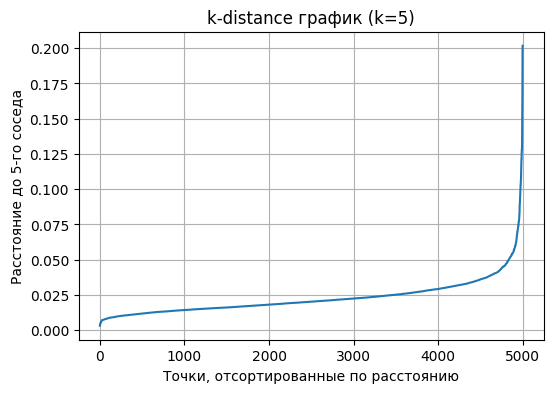

In [53]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

X_for_dbscan = doc_vectors_2d  # или другие признаки
k = 5  # это min_samples

# 1–2. считаем расстояния до k-го соседа
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_for_dbscan)
distances, indices = neigh.kneighbors(X_for_dbscan)

# расстояние до k-го соседа (столбец k-1)
k_distances = np.sort(distances[:, k-1])

# 3–4. строим график
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title(f"k-distance график (k={k})")
plt.xlabel("Точки, отсортированные по расстоянию")
plt.ylabel(f"Расстояние до {k}-го соседа")
plt.grid(True)
plt.show()


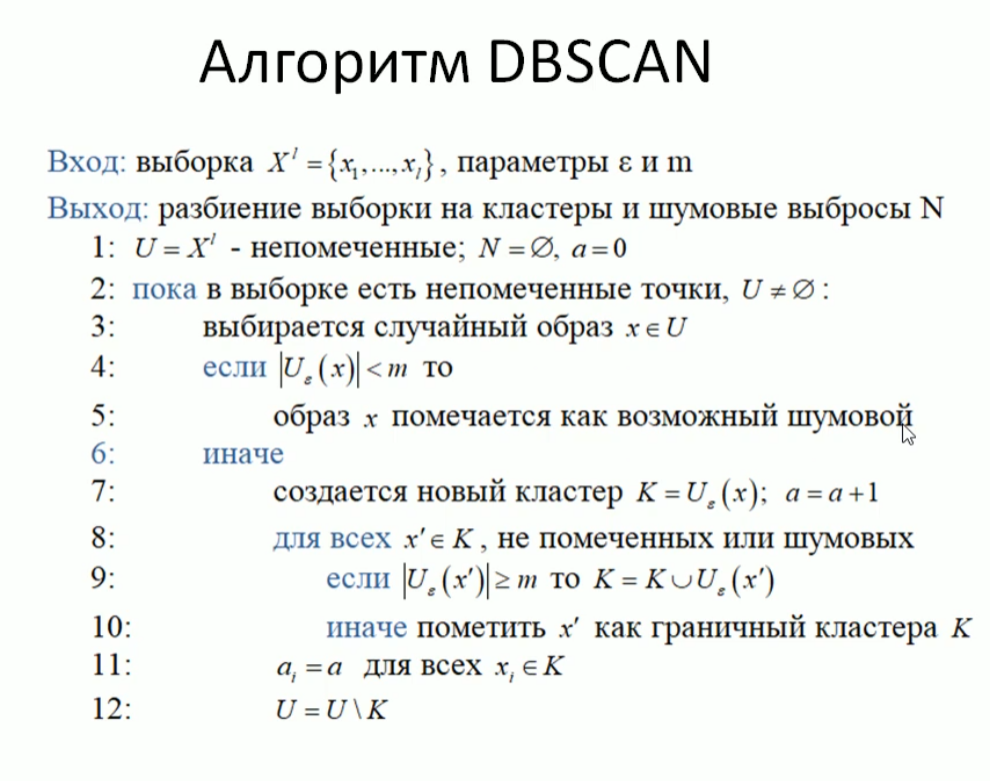

In [82]:
dbscan = DBSCAN(eps=0.029, min_samples=5)


cluster_labels = dbscan.fit_predict(doc_vectors_2d)

# -1 в DBSCAN означает "шум"
np.unique(cluster_labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69]),
 array([ 542, 3429,    6,   13,   44,   32,   24,   55,   31,  198,    7,
           8,    5,    9,    7,    6,   35,    6,   50,   18,   16,   16,
           5,    6,   32,   35,   12,    6,   12,   10,   12,    9,   30,
          16,   12,   10,    5,    9,   13,   16,   10,    8,   11,    7,
           6,    6,    6,    5,    9,    7,    9,    5,    9,    5,    5,
           6,    7,    4,    5,    6,    6,    7,    5,    5,    4,    5,
           5,    5,    5,    5,    5]))

In [83]:
df_subset["cluster"] = cluster_labels
df_subset[["title", "cluster"]].head(10)

,title,cluster
0,"Три машины столкнулись в Михайловском районе, ...",-1
1,На трассе в районе Морского кладбища монтируют...,0
2,Во Владивостоке запретили выход на лёд,0
3,"Хакатон по робототехнике, конкурс красоты и яр...",0
4,Во Владивостоке разворачивается нелегальная то...,0
5,"Водителя, который пьяным пытался скрыться от п...",49
6,Тротуар и дорогу у пляжа МГУ Невельского во Вл...,0
7,На выходных во Владивостоке будет до +5 °C,-1
8,Часть берега в порту Славянки под морвокзалом ...,0
9,Приморский «Адмирал» потерпел 20-е поражение в...,0


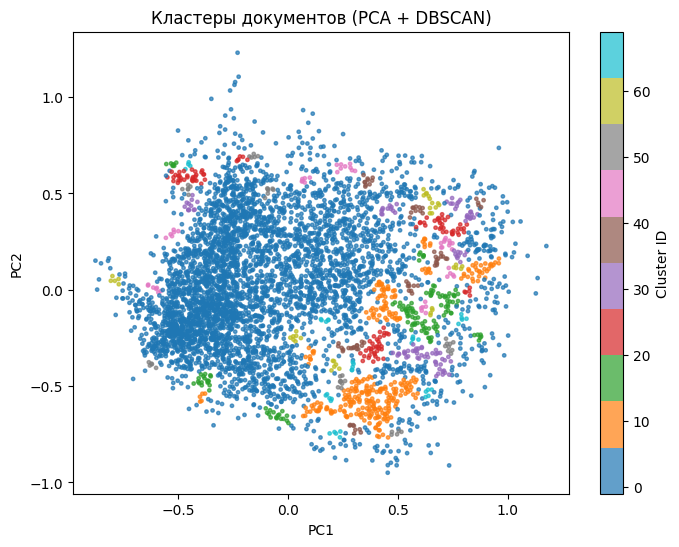

In [87]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов (PCA + DBSCAN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [105]:
cluster_id = 5

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)

,title
77,Во Владивостоке погиб водитель трактора-снегоу...
98,Во Владивостоке спасатели вынесли женщину из г...
187,В Приморье на скользкой дороге перевернулся бе...
271,Женщина-водитель с заклинившей педалью газа ус...
656,В Уссурийске пострадали четыре пассажира автоб...
674,Поезд столкнулся с легковой машиной в Приморье...
1793,"В Приморье мужчина погиб на пожаре в бане, обо..."
1892,Неосторожность при курении в постели унесла жи...
1953,Из перевернувшегося грузовика со скальником в ...
2172,В горевшем доме в Трудовом погибла женщина


In [101]:
cluster_id = 13

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)

,title
149,В субботу во Владивостоке снова может пойти до...
212,К вечеру во Владивостоке ожидается понижение т...
1312,Суббота во Владивостоке будет ветреной и холод...
2943,В выходные в Приморье повсеместно пройдут дожд...
3224,Сегодня во Владивостоке до +30 °С
3628,В предстоящие выходные осадки во Владивостоке ...
4725,Небольшой дождь возможен во Владивостоке в пер...


## Предсказать кластеры методом DecisionTree

фильтруем шум DBSCAN так как decisiontree не умеет с ним работать

In [116]:
# Оставляем только объекты, которые DBSCAN отнёс к какому-то кластеру (cluster != -1)
mask_non_noise = df_subset["cluster"] != -1
df_sup = df_subset[mask_non_noise].copy()

print(
    "Всего объектов для supervised-задачи:",
    len(df_sup),
    "из",
    len(df_subset),
)

# Целевая переменная — номер кластера
y = df_sup["cluster"].astype(int)

y.value_counts().sort_index()


Всего объектов для supervised-задачи: 4458 из 5000


,count
cluster,
0,3429
1,6
2,13
3,44
4,32
...,...
65,5
66,5
67,5


In [118]:
numeric_features = df_sup[["comments_count", "rating"]].copy()

imputer = SimpleImputer(strategy="median")

numeric_imputed = imputer.fit_transform(numeric_features)
numeric_imputed[:5]


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [126]:
# Индексы документов, которые попали в df_sup
idx = df_sup.index.to_numpy()

# Берём соответствующие векторы документов
doc_vectors_sup = doc_vectors[idx]

# Собираем общий набор признаков
X_features = np.hstack([doc_vectors_sup, numeric_imputed])
X_features.shape


(4458, 102)

In [130]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((3566, 102), (892, 102))

In [135]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X = X_features  # Уже готово: (N, 102) гибридные признаки
y = df_sup["cluster"].astype(int)

print("Форма данных:", X.shape)
print("Классы:", np.unique(y, return_counts=True))
print(f"Объектов для обучения: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,  # 70% train, 30% test
    random_state=42,
    stratify=y
)

print("Train/Test формы:", X_train.shape, X_test.shape)

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"],
}

grid_dt = GridSearchCV( # тюнинг
    estimator=dt,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,           # 3-fold кросс-валидация
    n_jobs=-1,      # Все ядра CPU
)

grid_dt.fit(X_train, y_train)

print("Лучшие параметры:", grid_dt.best_params_)
print("Лучший CV accuracy:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))


Форма данных: (4458, 102)
Классы: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69]), array([3429,    6,   13,   44,   32,   24,   55,   31,  198,    7,    8,
          5,    9,    7,    6,   35,    6,   50,   18,   16,   16,    5,
          6,   32,   35,   12,    6,   12,   10,   12,    9,   30,   16,
         12,   10,    5,    9,   13,   16,   10,    8,   11,    7,    6,
          6,    6,    5,    9,    7,    9,    5,    9,    5,    5,    6,
          7,    4,    5,    6,    6,    7,    5,    5,    4,    5,    5,
          5,    5,    5,    5]))
Объектов для обучения: 4458
Train/Test формы: (3120, 102) (1338, 102)
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Л

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Предсказать кластеры методом KNN

In [136]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

X = X_features
y = df_sup["cluster"].astype(int)

print("Форма данных:", X.shape)
print("Классы:", np.unique(y, return_counts=True))
print(f"Объектов для обучения: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train/Test формы:", X_train.shape, X_test.shape)

knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [3, 5, 10, 15],      # Количество соседей
    "weights": ["uniform", "distance"],  # uniform=равный вес, distance=1/расстояние
    "metric": ["cosine", "euclidean"],
}

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший CV accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report (KNN):")
print(classification_report(y_test, y_pred))


Форма данных: (4458, 102)
Классы: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69]), array([3429,    6,   13,   44,   32,   24,   55,   31,  198,    7,    8,
          5,    9,    7,    6,   35,    6,   50,   18,   16,   16,    5,
          6,   32,   35,   12,    6,   12,   10,   12,    9,   30,   16,
         12,   10,    5,    9,   13,   16,   10,    8,   11,    7,    6,
          6,    6,    5,    9,    7,    9,    5,    9,    5,    5,    6,
          7,    4,    5,    6,    6,    7,    5,    5,    4,    5,    5,
          5,    5,    5,    5]))
Объектов для обучения: 4458
Train/Test формы: (3120, 102) (1338, 102)
Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Лучший CV accuracy: 0.8

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
